loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
1231


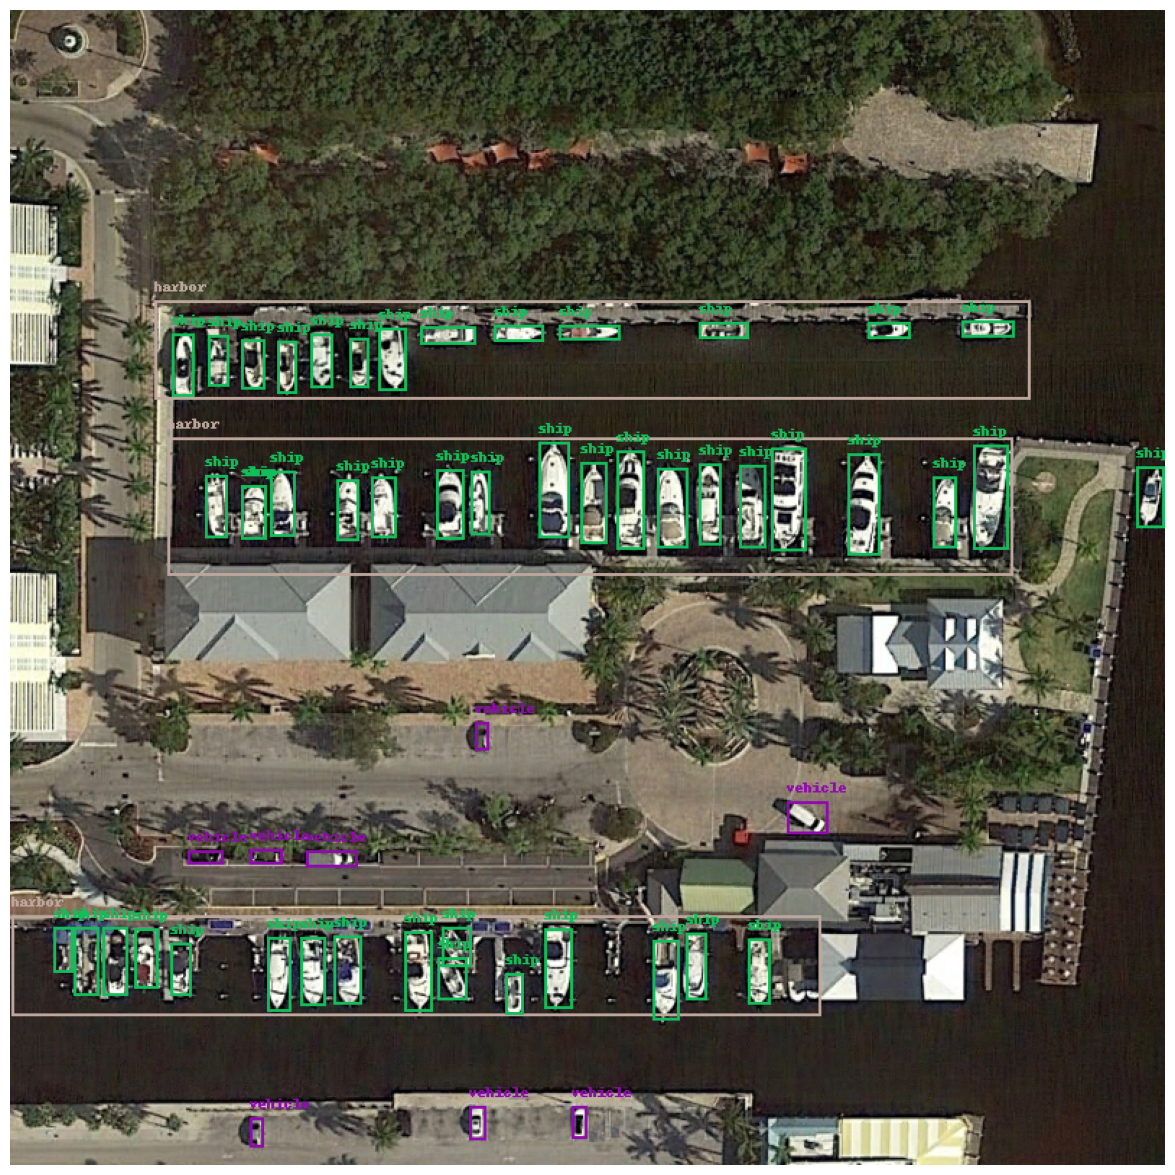

In [17]:
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np

def get_random_color():
    """生成随机颜色"""
    return tuple(np.random.choice(range(256), size=3))

def visualize_coco_annotation(coco, img_dir, img_id):
    """
    可视化指定图片ID的COCO标注。
    
    :param coco: COCO实例
    :param img_dir: 图像所在目录
    :param img_id: 图像ID
    """
    # 获取图像信息
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{img_dir}/{img_info['file_name']}"
    
    # 加载图像
    image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    
    # 获取该图像的所有标注
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(ann_ids)

    # 类别到颜色的映射
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    cat_to_color = {cat['id']: get_random_color() for cat in cats}

    try:
        font = ImageFont.truetype("arial.ttf", 15)  # 尝试加载字体
    except IOError:
        font = ImageFont.load_default()  # 如果失败，则使用默认字体

    for annotation in annotations:
        bbox = annotation['bbox']
        segmentation = annotation['segmentation']
        category_id = annotation['category_id']
        category_name = coco.loadCats([category_id])[0]['name']
        
        color = cat_to_color[category_id]

        # 绘制边界框
        if bbox:
            x, y, w, h = bbox
            draw.rectangle([x, y, x + w, y + h], outline=color, width=2)
            draw.text((x, y - 15), category_name, fill=color, font=font)
        
        # 绘制分割掩码
        if segmentation:
            if isinstance(segmentation, list):  # 多边形
                for poly in segmentation:
                    poly = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
                    draw.polygon(poly, outline=color)

    # 显示图像
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def main():
    # COCO数据集路径
    annotation_file = "/root/autodl-tmp/DIOR_coco/annotations/train.json"
    img_dir = "/root/autodl-tmp/DIOR_coco/train"

    # 初始化COCO API
    coco = COCO(annotation_file)

    # 随机选择一个图像ID
    img_ids = coco.getImgIds()
    
    selected_img_id = random.choice(img_ids)
    print(selected_img_id)
    selected_img_id = 4137 

    # 可视化选中的图像及标注
    visualize_coco_annotation(coco, img_dir, selected_img_id)

if __name__ == "__main__":
    main()

In [25]:
import json

def validate_coco_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)  # 这里需要传递文件对象 f 给 json.load()

    # 检查必需的顶级字段
    required_keys = ['images', 'annotations', 'categories']
    for key in required_keys:
        if key not in data:
            print(f"❌ 错误: 缺少必需字段 '{key}'")
            return False

    # 检查 images 列表
    image_ids = set()
    for img in data['images']:
        assert 'id' in img, "图像缺少 'id'"
        assert 'file_name' in img, f"图像 {img['id']} 缺少 'file_name'"
        assert isinstance(img['id'], (int, str)), f"图像ID必须是整数或字符串"
        image_ids.add(img['id'])

    # 检查 categories 列表
    cat_ids = set()
    for cat in data['categories']:
        assert 'id' in cat, "类别缺少 'id'"
        assert 'name' in cat, f"类别 {cat['id']} 缺少 'name'"
        cat_ids.add(cat['id'])

    # 检查 annotations 列表
    ann_image_ids = set()
    for ann in data['annotations']:
        # 必需字段
        assert 'image_id' in ann, "标注缺少 'image_id'"
        assert 'category_id' in ann, "标注缺少 'category_id'"
        
        # 验证 image_id 和 category_id 是否存在
        assert ann['image_id'] in image_ids, f"标注中的 image_id {ann['image_id']} 在 images 中不存在"
        assert ann['category_id'] in cat_ids, f"标注中的 category_id {ann['category_id']} 在 categories 中不存在"

        # 检查 bbox 格式
        if 'bbox' in ann and ann['bbox']:  # 允许 bbox 为空吗？
            assert len(ann['bbox']) == 4, f"Bbox 必须是4个元素的列表 [x, y, w, h], 得到的是 {ann['bbox']}"
            x, y, w, h = ann['bbox']
            assert all(isinstance(i, (int, float)) for i in [x,y,w,h]), "Bbox 坐标必须是数字"
            assert w > 0 and h > 0, f"Bbox 宽度或高度为非正数: {ann['bbox']}"

        # 可选：检查 area 是否与 bbox 一致
        if 'area' in ann and 'bbox' in ann:
            calc_area = ann['bbox'][2] * ann['bbox'][3]
            if abs(ann['area'] - calc_area) > 1e-6:
                print(f"⚠️ 警告: annotation ID={ann['id']} 的 area ({ann['area']}) 与 bbox 计算面积 ({calc_area}) 不符")

        ann_image_ids.add(ann['image_id'])

    # 报告统计信息
    print(f"✅ JSON 文件验证通过!")
    print(f"  图像数量: {len(data['images'])}")
    print(f"  类别数量: {len(data['categories'])}")
    print(f"  标注数量: {len(data['annotations'])}")
    print(f"  有标注的图像数量: {len(ann_image_ids)}")
    missing_anns = len(image_ids - ann_image_ids)
    print(f"  没有任何标注的图像数量: {missing_anns}")

    return True

# 使用示例
validate_coco_json('/root/autodl-tmp/DIOR_coco/annotations/test_nonempty.json')

✅ JSON 文件验证通过!
  图像数量: 11358
  类别数量: 20
  标注数量: 122672
  有标注的图像数量: 11358
  没有任何标注的图像数量: 0


True

In [21]:
import json

def create_non_empty_json(original_json_path, output_json_path):
    with open(original_json_path, 'r') as f:
        data = json.load(f)

    # 获取所有有标注的图像ID
    ann_img_ids = set(ann['image_id'] for ann in data['annotations'])
    
    # 过滤 images 列表
    filtered_images = [img for img in data['images'] if img['id'] in ann_img_ids]
    
    # annotations 和 categories 保持不变
    filtered_data = {
        'images': filtered_images,
        'annotations': data['annotations'],
        'categories': data['categories']
    }

    with open(output_json_path, 'w') as f:
        json.dump(filtered_data, f, indent=2)
    
    print(f"✅ 已创建新JSON文件，包含 {len(filtered_images)} 张有标注的图像")
    print(f"   保存至: {output_json_path}")

# 使用示例
create_non_empty_json(
    '/root/autodl-tmp/DIOR_coco/annotations/train.json',
    '/root/autodl-tmp/DIOR_coco/annotations/train_nonempty.json'
)
# 使用示例
create_non_empty_json(
    '/root/autodl-tmp/DIOR_coco/annotations/val.json',
    '/root/autodl-tmp/DIOR_coco/annotations/val_nonempty.json'
)
# 使用示例
create_non_empty_json(
    '/root/autodl-tmp/DIOR_coco/annotations/test.json',
    '/root/autodl-tmp/DIOR_coco/annotations/test_nonempty.json'
)

✅ 已创建新JSON文件，包含 5668 张有标注的图像
   保存至: /root/autodl-tmp/DIOR_coco/annotations/train_nonempty.json
✅ 已创建新JSON文件，包含 5687 张有标注的图像
   保存至: /root/autodl-tmp/DIOR_coco/annotations/val_nonempty.json
✅ 已创建新JSON文件，包含 11358 张有标注的图像
   保存至: /root/autodl-tmp/DIOR_coco/annotations/test_nonempty.json


In [ ]:
import json

def validate_and_locate_invalid_bboxes(json_path):
    """
    验证COCO JSON，并精确定位包含无效bbox的图片。
    :param json_path: COCO JSON文件路径
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    # 创建一个从 image_id 到 file_name 的映射
    img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    
    invalid_count = 0
    problematic_img_ids = set()  # 记录包含无效标注的图片ID

    print("🔍 开始检查所有标注...")

    for ann in data['annotations']:
        ann_id = ann.get('id', 'unknown')
        image_id = ann.get('image_id', None)
        
        # 如果无法获取image_id，跳过并报错
        if image_id is None:
            print(f"❌ 标注 ID={ann_id} 缺少 'image_id' 字段！")
            invalid_count += 1
            continue
            
        # 获取对应的图片文件名
        filename = img_id_to_filename.get(image_id, "UNKNOWN_FILE")
        
        # 检查bbox
        if 'bbox' in ann and ann['bbox']:
            try:
                x, y, w, h = ann['bbox']
                if w <= 0 or h <= 0:
                    print(f"❌ 发现无效bbox!")
                    print(f"   ├─ Annotation ID: {ann_id}")
                    print(f"   ├─ Image ID: {image_id}")
                    print(f"   ├─ Image File: {filename}")
                    print(f"   └─ Bbox [x, y, w, h]: [{x}, {y}, {w}, {h}]")
                    invalid_count += 1
                    problematic_img_ids.add(image_id)
            except Exception as e:
                print(f"⚠️  标注 ID={ann_id} 的bbox格式错误: {ann['bbox']} - 错误: {e}")
                invalid_count += 1
                problematic_img_ids.add(image_id)

    # 最终报告
    print("\n" + "="*60)
    if invalid_count == 0:
        print("🎉 恭喜！未发现任何无效的边界框。")
    else:
        print(f"🚨 共发现 {invalid_count} 个无效的边界框，涉及 {len(problematic_img_ids)} 张图片。")
        print("\n📋 包含无效标注的图片列表 (Image ID 和 文件名):")
        for img_id in sorted(problematic_img_ids):
            fname = img_id_to_filename.get(img_id, "UNKNOWN")
            print(f"   • Image ID: {img_id} -> '{fname}'")

    return list(problematic_img_ids)

# 使用示例
json_path = '/root/autodl-tmp/DIOR_coco/annotations/train.json'
problematic_images = validate_and_locate_invalid_bboxes(json_path)

🔍 开始检查所有标注...

🎉 恭喜！未发现任何无效的边界框。


In [26]:
import json

with open("/root/autodl-tmp/DIOR_coco/annotations/train.json", "r") as f:
    data = json.load(f)

annotations = data["annotations"]
for ann in annotations:
    assert "bbox" in ann, f"Annotation {ann['id']} has no bbox"
    assert len(ann["bbox"]) == 4, f"Invalid bbox length: {ann['bbox']}"
    assert "category_id" in ann, f"Missing category_id: {ann}"